In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
from collections import defaultdict
import csv
from scipy.io import loadmat
from scipy.signal import find_peaks

import corrected jaw pixel intensity in camera frames, list of 2p frame start times in nidaq time, and list of side camera frame start times in nidaq time

In [142]:
jaw = np.loadtxt('/vol/cortex/cd1/Analysis/lyndsay/M136/2024-10-16/full/behavior/corrected_jaw.txt')
twop_frames = np.loadtxt('/vol/cortex/cd1/Analysis/lyndsay/M136/2024-10-16/full/frames/twop_frames_downsample4.txt')
sidecam_frames = np.loadtxt('/vol/cortex/cd1/Analysis/lyndsay/M136/2024-10-16/full/frames/sidecam_frames.txt')

import background behavior pixel intensity in camera frames

In [180]:
behavior_background = []
file_path_2 = '/vol/cortex/cd1/Analysis/lyndsay/M136/2024-10-16/full/behavior/background_pixel_intensity.csv'
with open(file_path_2) as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        behavior_background.append(row[1])
behavior_background = behavior_background[1::]
behavior_background = np.array(behavior_background, dtype=float)

import calcium traces, one for each cell (n=16) over 9000 frames (7.5 hz)

In [18]:
C = np.load('/vol/cortex/cd1/Analysis/lyndsay/M136/2024-10-16/full/manual_masks.npy')

import cell ROIs

In [27]:
A = np.load('/vol/cortex/cd1/Analysis/lyndsay/M136/2024-10-16/full/A_original.npy')

import bpod data, including trial start times and lick times

In [ ]:
bpod_data = loadmat('/vol/cortex/cd1/Data/lyndsay/Behavior/M136/20241016/M136_TwoPhoton_OneSpoutGNG_20241016_153542.mat')

#### lick bpod times. couldn't correctly align to camera and 2p data. didn't use for presentation

In [183]:
session_data = bpod_data['SessionData']
raw_data = session_data[0][0][4]
original_event_timestamps = raw_data[0][0][4][0]     # each entry is a trial, which holds the time stamps of each lick relative to trial start in seconds
trial_start_timestamp = session_data[0][0][5][0]     # array of trial starts in seconds
trial_end_timestamp = session_data[0][0][6][0]       # array of trial ends in seconds

In [126]:
# unpack to get one array with all lick times in seconds, unsplit by trial

lick_times_absolute = []

for i, trial_start in enumerate(trial_start_timestamp):
    lick_times_absolute.extend(trial_start+original_event_timestamps[i])

lick_times_doublecounted = []

for i, trial in enumerate(lick_times_absolute):
    lick_times_doublecounted.extend(lick_times_absolute[i])

lick_times_doublecounted = np.round(lick_times_doublecounted, 5)

In [82]:
print(trial_start_timestamp[0])
print(trial_end_timestamp[-1])

17.3022
1220.0582


6024
1164


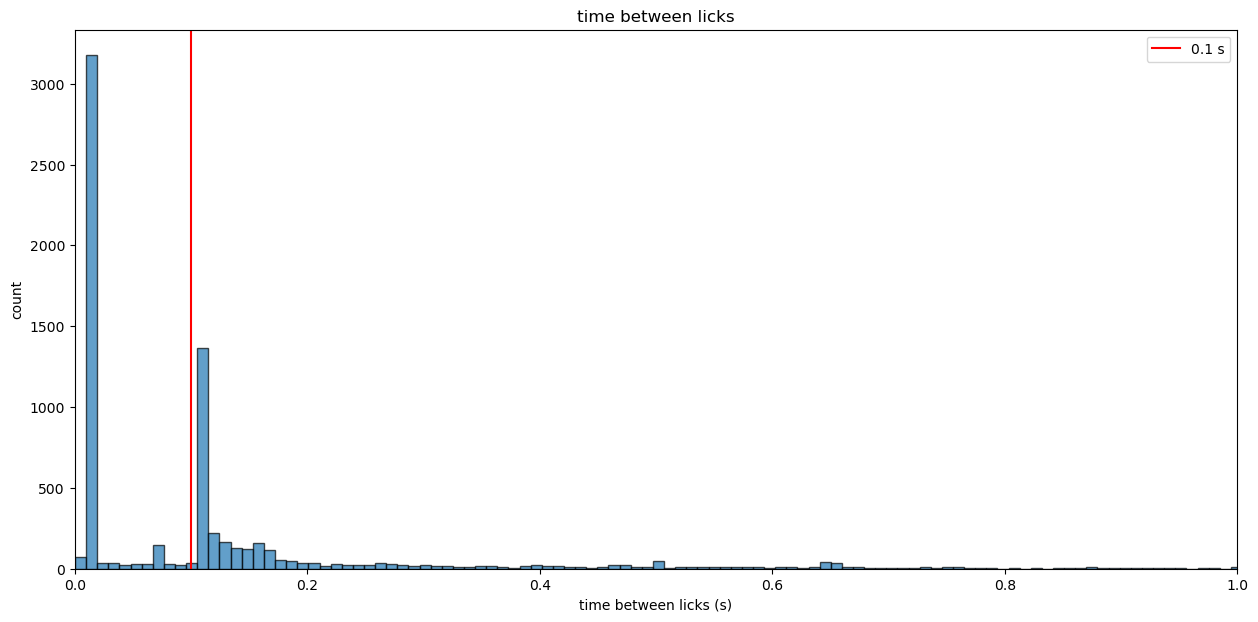

In [127]:
lick_diffs_doublecounted = np.diff(lick_times_doublecounted)
print(np.sum(lick_diffs < 0.2))
print(np.sum(lick_diffs > 0.2))

plt.figure(figsize=(15, 7))
plt.hist(lick_diffs, bins=500, edgecolor='black', alpha=0.7)  # Adjust 'bins' if necessary
plt.xlabel('time between licks (s)')
plt.ylabel('count')
plt.axvline(0.1, color='r', label='0.1 s')
plt.title('time between licks')
plt.xlim(0, 1)
plt.legend()
plt.show()

In [99]:
np.unique(lick_diffs)[0:5]

array([0.0002, 0.0002, 0.0004, 0.0006, 0.0007])

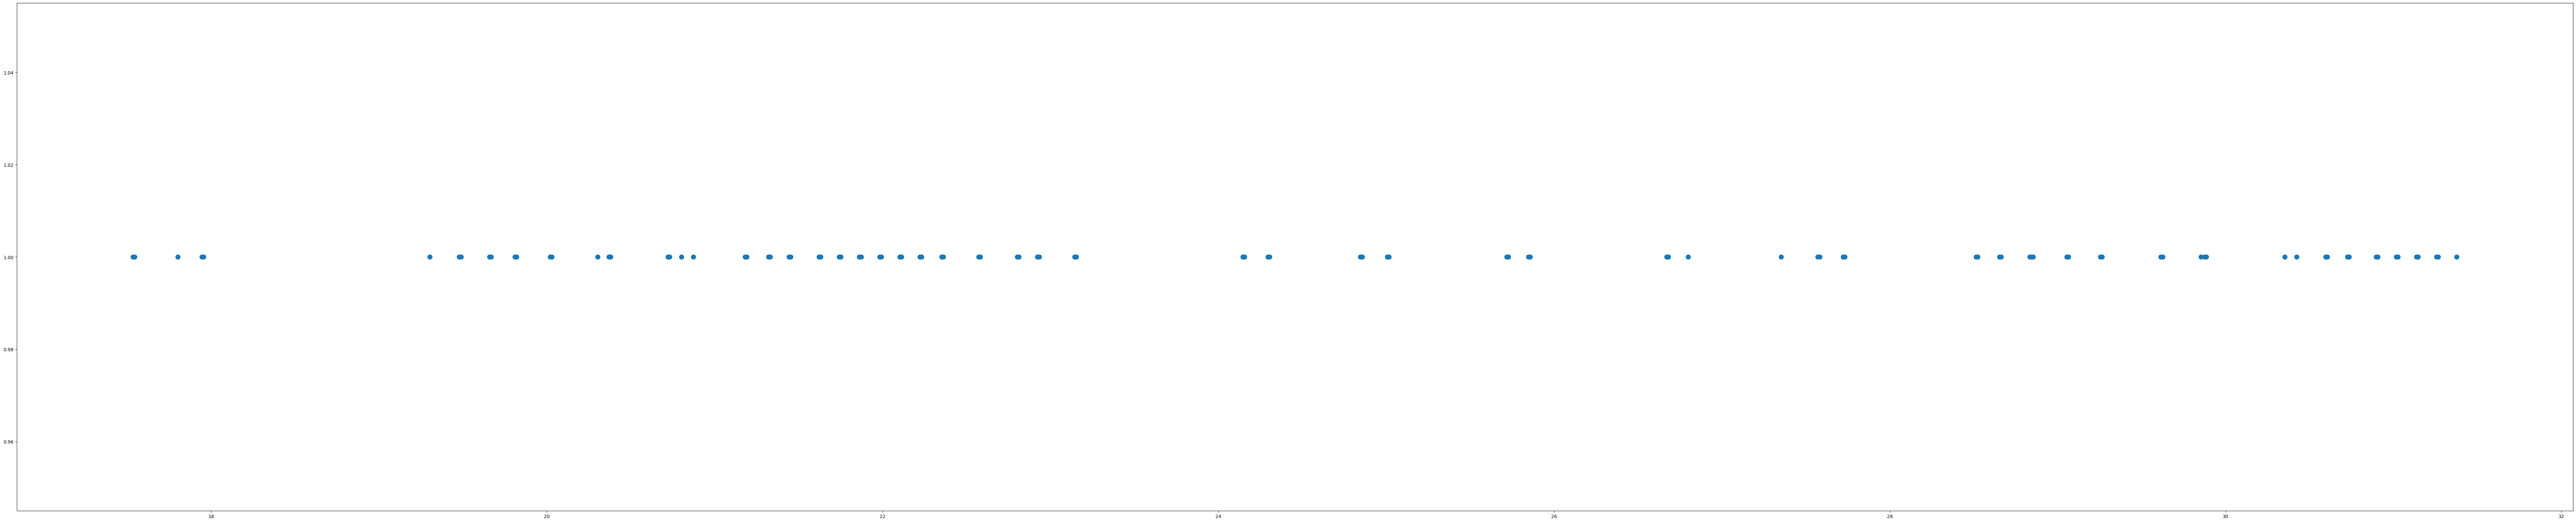

In [129]:
plt.figure(figsize = (100,20))
plt.scatter(lick_times_doublecounted[0:100], np.full(100, 1), s=100)
plt.show()

In [132]:
# find the indices of lick_diffs > 0.05
lick_diffs_05 = np.where(lick_diffs_doublecounted > 0.05)[0]
lick_times = lick_times_doublecounted[lick_diffs_05 + 1]

print(lick_diffs_05)
print(lick_times_doublecounted[0:10])
print(lick_times[0:10])

[   1    2    4 ... 7183 7185 7187]
[17.5345 17.5445 17.8022 17.9452 17.9552 19.3022 19.4784 19.4884 19.6586
 19.6686]
[17.8022 17.9452 19.3022 19.4784 19.6586 19.8087 20.0189 20.3022 20.3695
 20.7201]


175
105


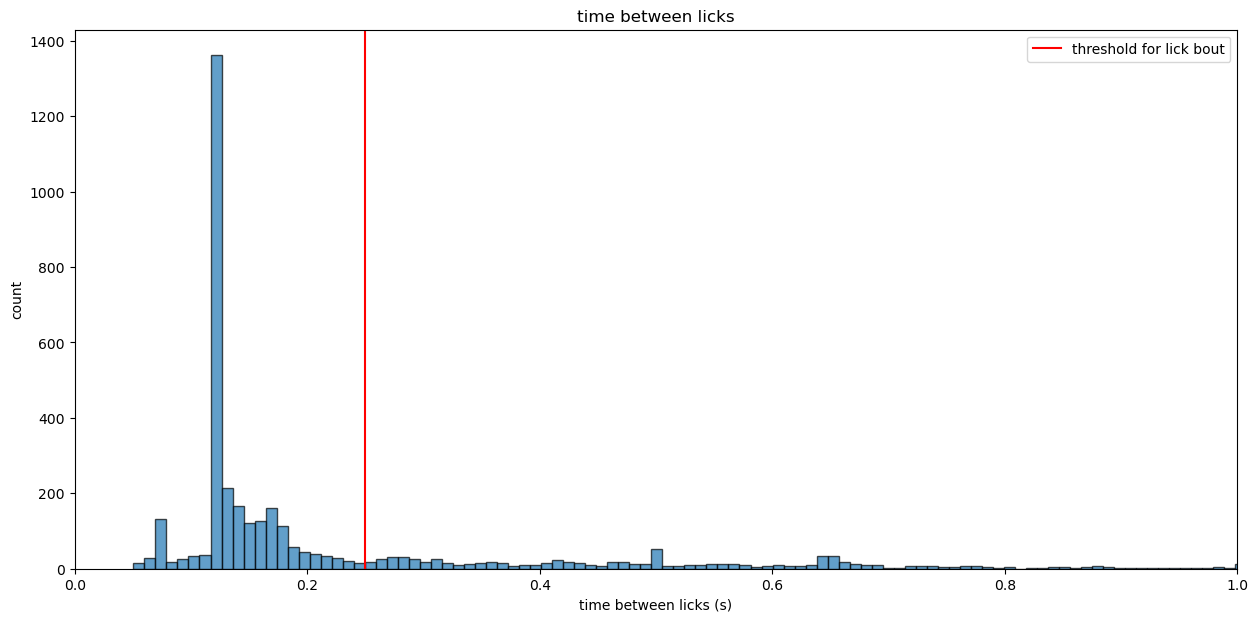

In [196]:
# plot histogram after doublecounted licks are removed
lick_diffs = np.diff(lick_times)
print(np.sum(lick_diffs < 0.2))
print(np.sum(lick_diffs > 0.2))

plt.figure(figsize=(15, 7))
plt.hist(valid_lick_diffs, bins=500, edgecolor='black', alpha=0.7)  # Adjust 'bins' if necessary
plt.xlabel('time between licks (s)')
plt.ylabel('count')
plt.axvline(0.25, color='r', label='threshold for lick bout')
plt.title('time between licks')
plt.xlim(0, 1)
plt.legend()
plt.show()

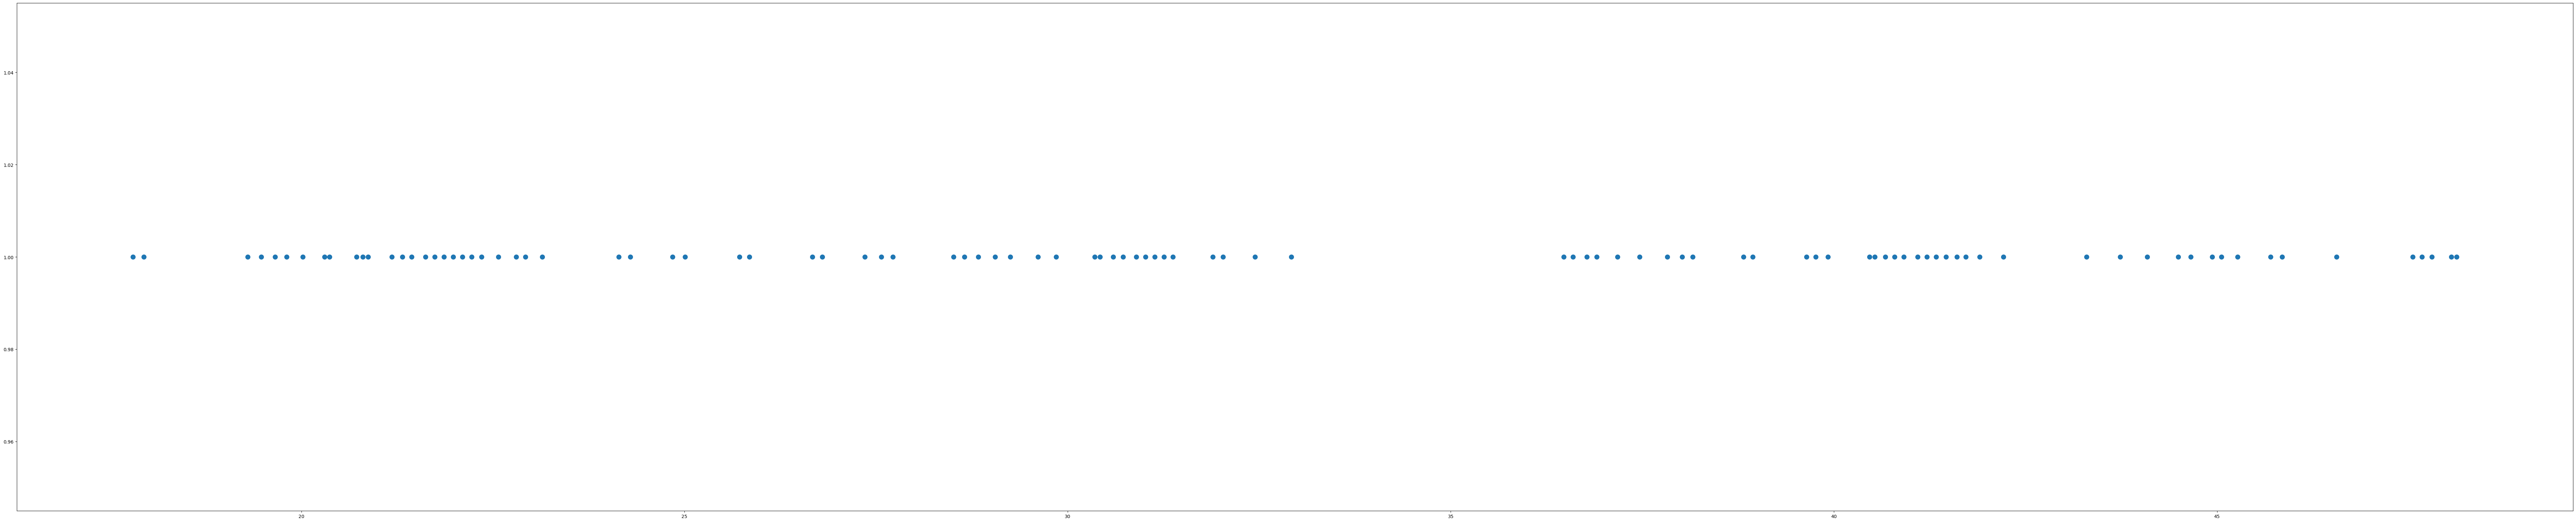

In [153]:
# confirm double counted licks are removed
plt.figure(figsize = (100,20))
plt.scatter(lick_times[0:100], np.full(100, 1), s=100)
plt.show()

##### try to align bpod start times to camera start times

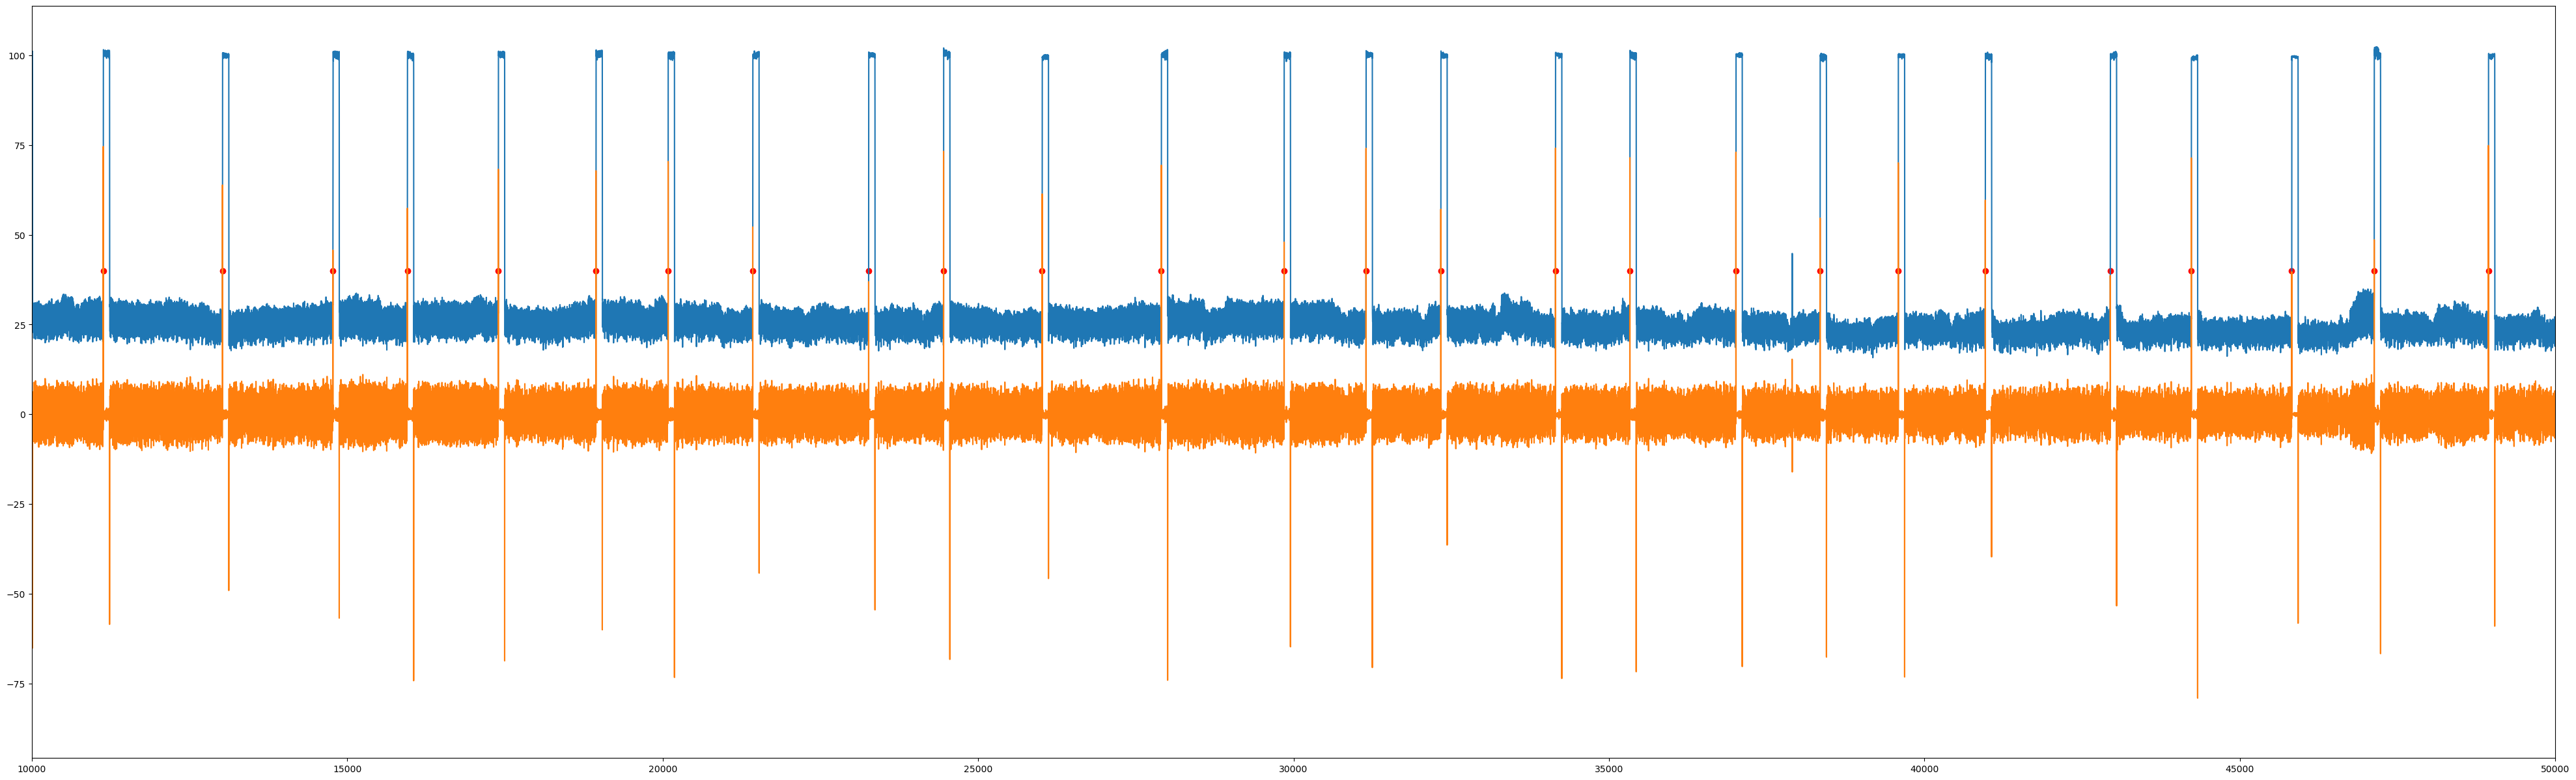

In [181]:
# find trial start times in behavior camera world, based on leds

cam_diffs = np.diff(behavior_background)

background_peaks = find_peaks(cam_diffs, prominence=20, distance=1100)[0]

plt.figure(figsize=(50, 15))
plt.plot(behavior_background)
plt.plot(cam_diffs)
plt.scatter(background_peaks, np.full(len(background_peaks), 40), color='r')
plt.xlim(10000, 50000)
plt.show()

In [184]:
# check offset between bpod time (lick events) and camera time (related to nidaq time)
background_peaks_sec = background_peaks / 200
print(background_peaks_sec)
print(len(background_peaks_sec))

offset = trial_start_timestamp - background_peaks_sec[0:-1]
print(offset)

[  12.25    21.8     31.915   39.505   49.545   55.65    65.1     73.855
   79.755   86.965   94.705  100.425  107.13   116.315  122.255  130.07
  139.515  149.25   155.74   161.67   170.76   176.655  185.06   191.735
  197.93   204.825  214.73   221.155  229.115  235.655  244.705  253.12
  259.305  266.435  272.65   279.15   288.62   297.23   306.32   313.6
  320.23   330.735  340.56   351.07   357.87   366.56   375.055  380.99
  386.97   397.19   404.24   414.19   424.73   431.41   441.09   447.925
  455.365  464.33   471.775  481.855  492.47   498.925  508.35   516.345
  524.405  533.335  540.045  549.835  558.665  568.625  574.875  582.32
  589.595  597.085  603.335  613.54   620.51   629.105  638.92   647.85
  655.165  665.34   671.905  678.955  686.33   696.075  703.815  712.56
  718.975  726.375  734.12   744.06   749.895  759.84   766.05   771.84
  781.61   789.63   797.5    807.005  815.035  821.585  832.305  841.98
  850.73   859.635  868.47   874.57   885.25   892.23   902.5

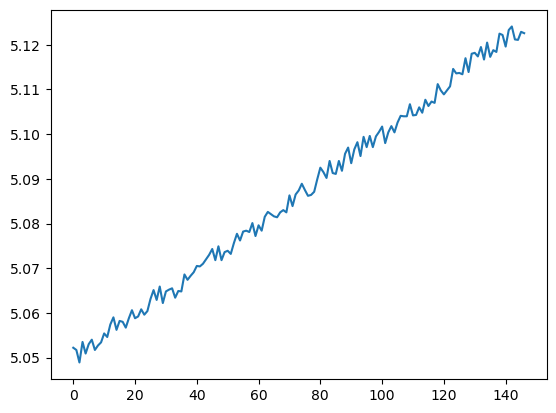

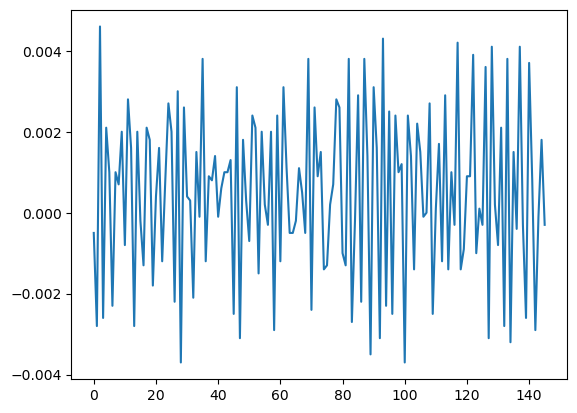

In [185]:
plt.plot(offset)
plt.show()
plt.plot(np.diff(offset))

In [215]:
trial_start_timestamp = trial_start_timestamp[0:10]  # in bpod time
print(trial_start_timestamp)
led_times = background_peaks[0:10]               # in camera time
led_times_sec = led_times / 200
print(led_times_sec)

[17.3022 26.8517 36.9639 44.5585 54.5959 60.703  70.154  78.9067 84.8077
 92.0184]
[12.25  21.8   31.915 39.505 49.545 55.65  65.1   73.855 79.755 86.965]


In [214]:
original_event_timestamps = original_event_timestamps[0:10]
print(original_event_timestamps.shape)
print(led_times.shape)
print(led_times)

(10,)
(10,)
[ 2450  4360  6383  7901  9909 11130 13020 14771 15951 17393]


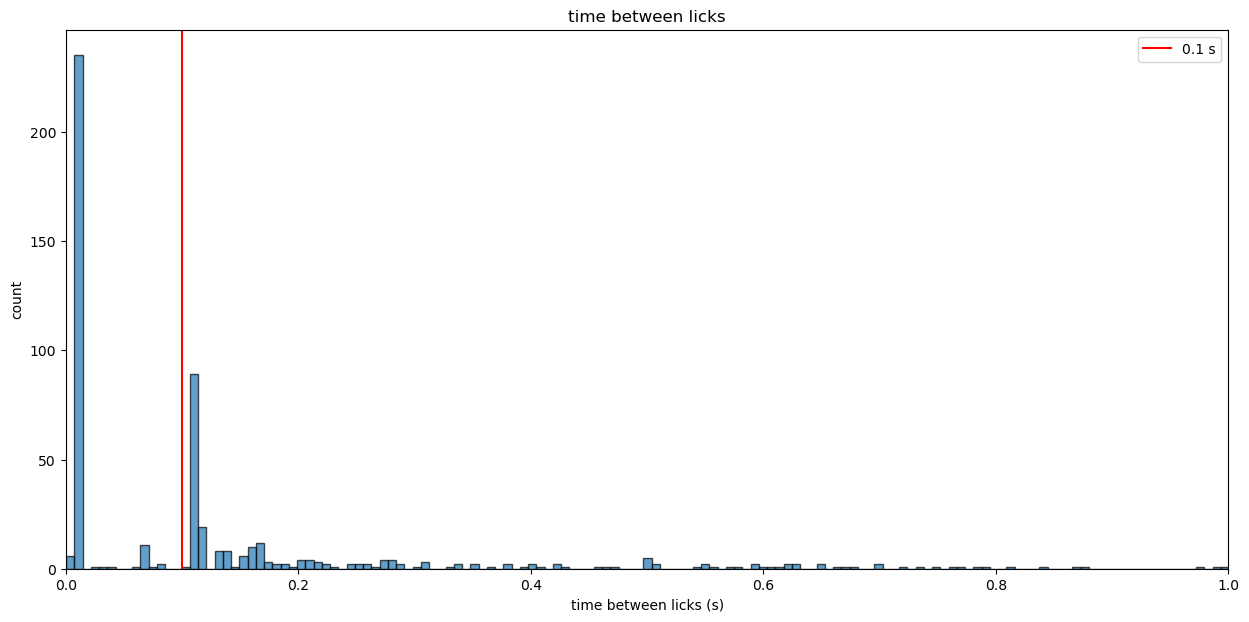

In [217]:
# unpack to get one array with all lick times in seconds, unsplit by trial

lick_times_absolute = []

for i, trial_start in enumerate(led_times_sec):
    lick_times_absolute.extend(trial_start+original_event_timestamps[i])

lick_times_doublecounted = []

for i, trial in enumerate(lick_times_absolute):
    lick_times_doublecounted.extend(lick_times_absolute[i])

lick_times_doublecounted = np.round(lick_times_doublecounted, 5)

lick_diffs_doublecounted = np.diff(lick_times_doublecounted)

plt.figure(figsize=(15, 7))
plt.hist(lick_diffs_doublecounted, bins=500, edgecolor='black', alpha=0.7)  # Adjust 'bins' if necessary
plt.xlabel('time between licks (s)')
plt.ylabel('count')
plt.axvline(0.1, color='r', label='0.1 s')
plt.title('time between licks')
plt.xlim(0, 1)
plt.legend()
plt.show()

89


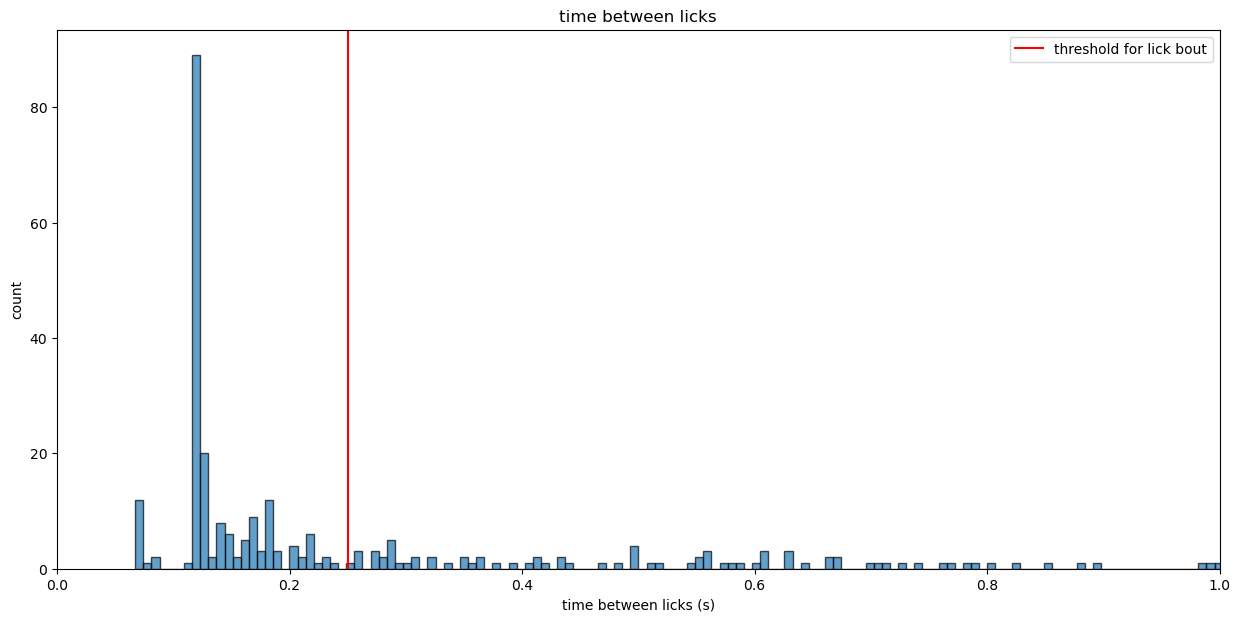

In [218]:
# find the indices of lick_diffs > 0.05
lick_diffs_05 = np.where(lick_diffs_doublecounted > 0.05)[0]
lick_times = lick_times_doublecounted[lick_diffs_05 + 1]

# plot histogram after doublecounted licks are removed
lick_diffs = np.diff(lick_times)
print(np.sum(lick_diffs > 0.25))

plt.figure(figsize=(15, 7))
plt.hist(lick_diffs, bins=500, edgecolor='black', alpha=0.7)  # Adjust 'bins' if necessary
plt.xlabel('time between licks (s)')
plt.ylabel('count')
plt.axvline(0.25, color='r', label='threshold for lick bout')
plt.title('time between licks')
plt.xlim(0, 1)
plt.legend()
plt.show()

88


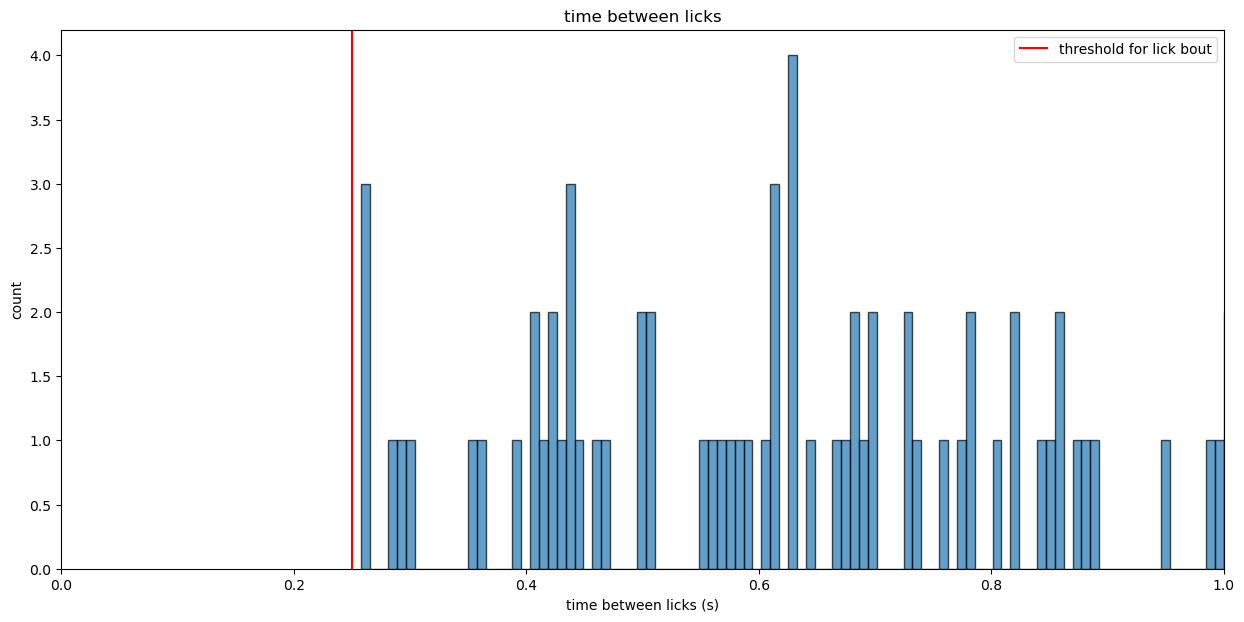

In [172]:
## find indices of licks above 0.25 s threshold
lick_diffs_25 = np.where(lick_diffs > 0.25)[0]
lick_times_bout = lick_times[lick_diffs_25 + 1]

# plot histogram after doublecounted licks are removed
lick_diffs_bout = np.diff(lick_times_bout)
print(len(lick_diffs_bout))

plt.figure(figsize=(15, 7))
plt.hist(lick_diffs_bout, bins=500, edgecolor='black', alpha=0.7)  # Adjust 'bins' if necessary
plt.xlabel('time between licks (s)')
plt.ylabel('count')
plt.axvline(0.25, color='r', label='threshold for lick bout')
plt.title('time between licks')
plt.xlim(0, 1)
plt.legend()
plt.show()

In [305]:
print(lick_times[-1]*200)

18914.9


#### offsets between bpod start times and camera start times are variable :/ look at 10 trials of licking for presentation

plot 4000 frames of licking behavior to visualize

Text(0, 0.5, 'jaw motion (pixel intensity)')

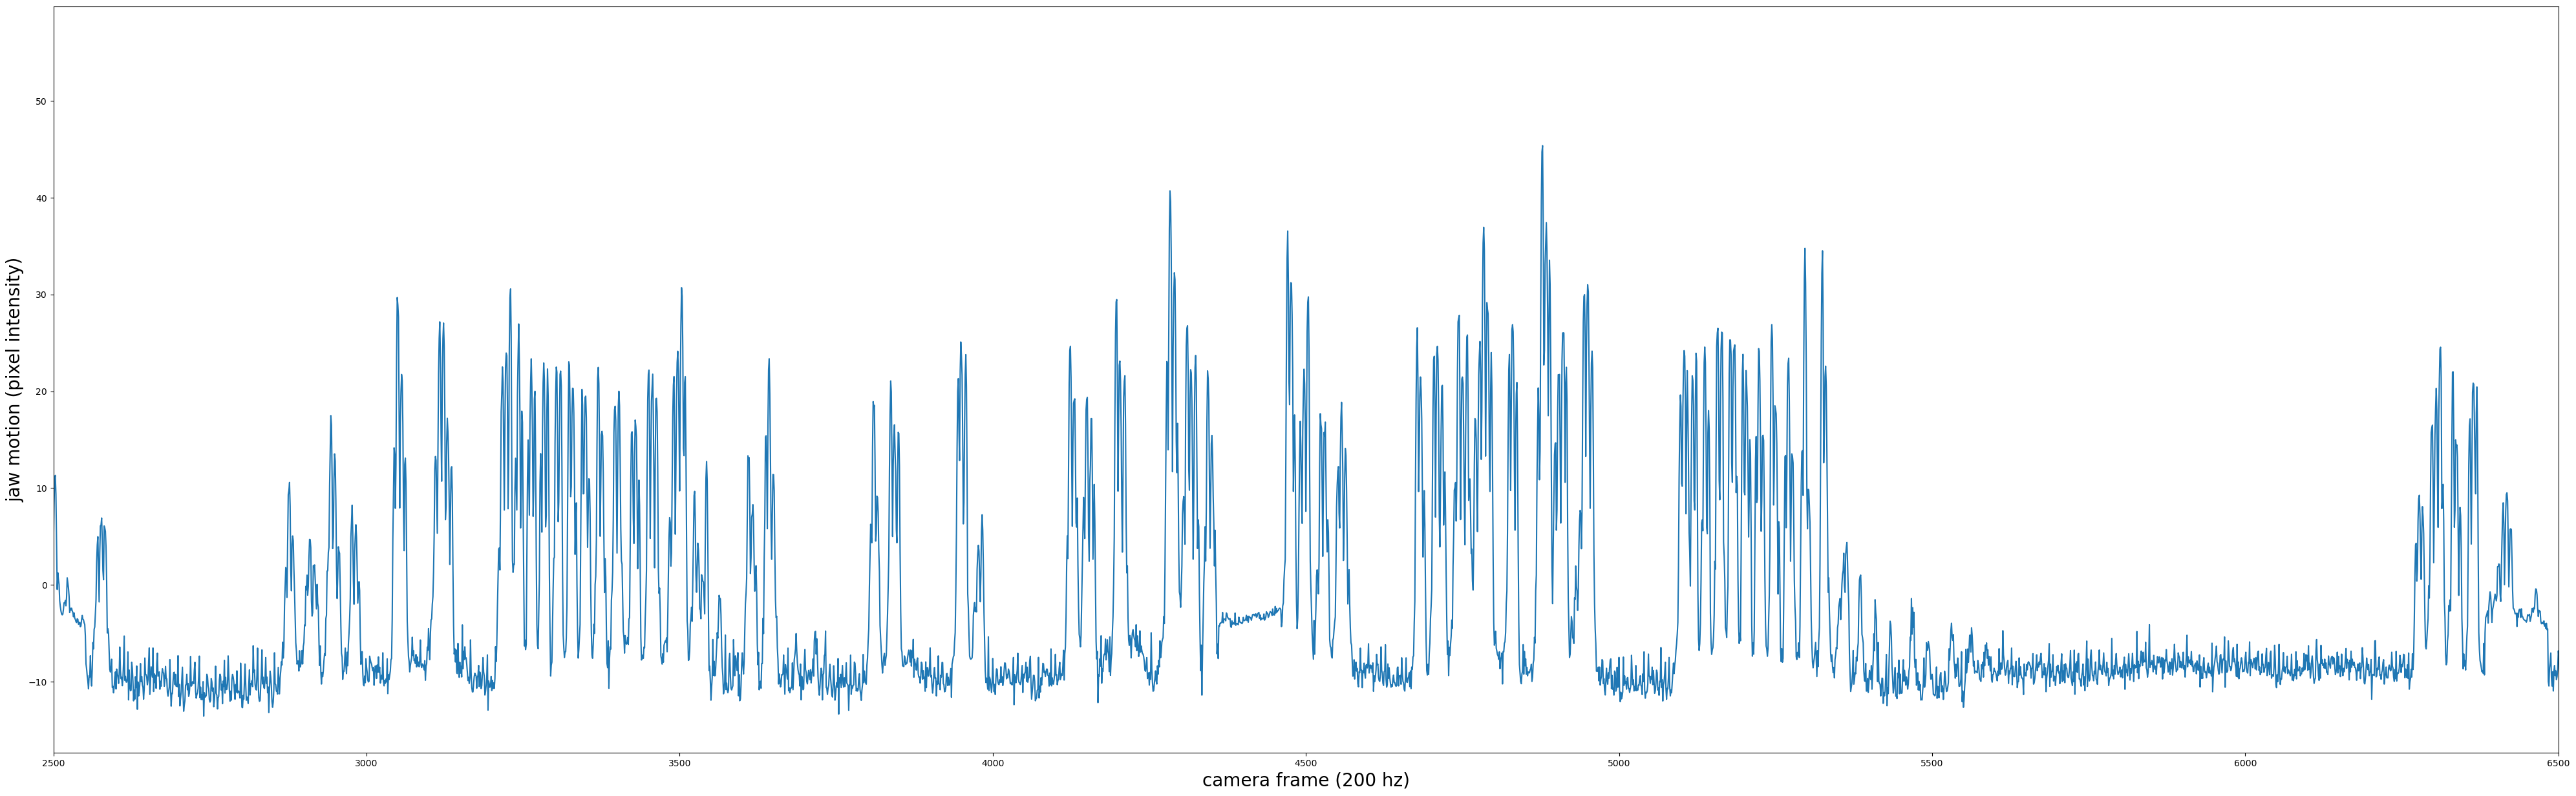

In [541]:
plt.figure(figsize = (50, 15))
plt.plot(jaw)
#plt.scatter(lick_times*200, np.full(len(lick_times), 30))
#for time in led_times:
    #plt.axvline(x=time, color='r')
plt.xlim(2500, 6500)
plt.xlabel('camera frame (200 hz)', fontsize=20)
plt.ylabel('jaw motion (pixel intensity)', fontsize=20)

find 10 licking bouts that have similar activity patterns. plot together

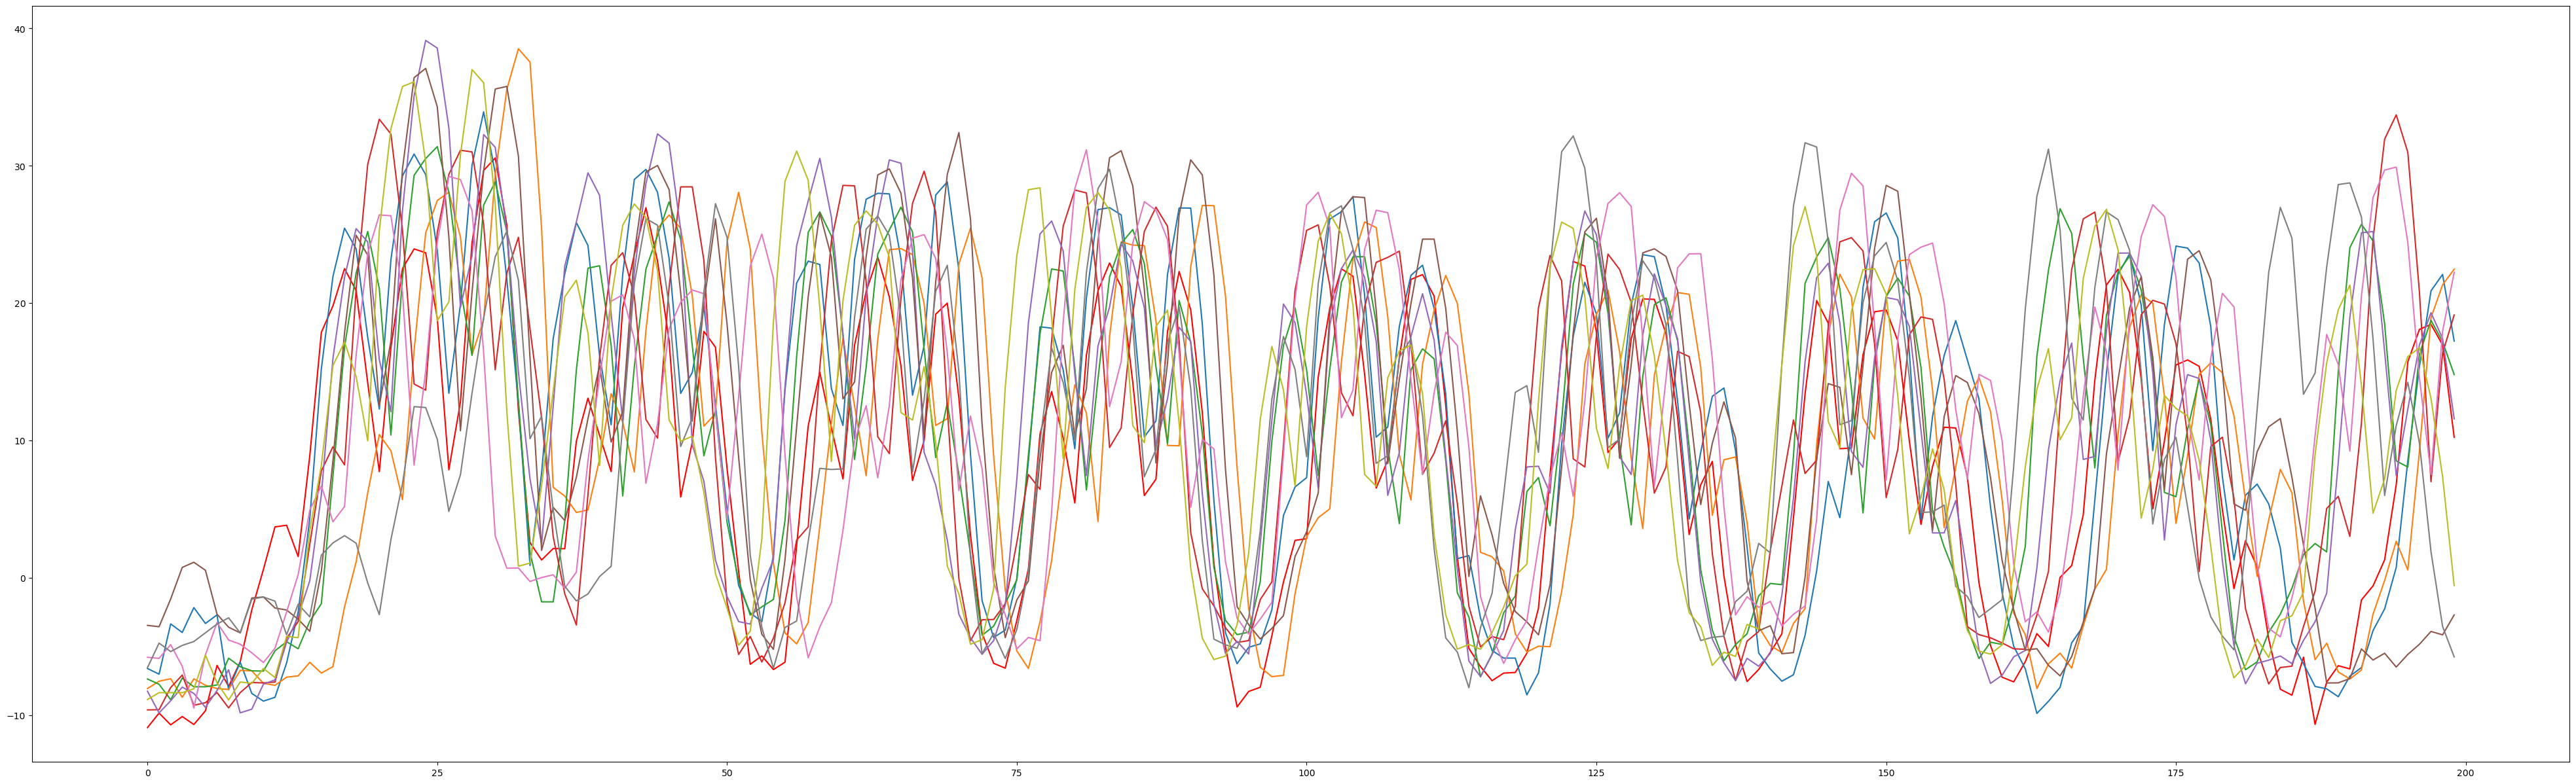

In [353]:
plt.figure(figsize=(50, 15))
plt.plot(jaw[3200:3400], color='r')
plt.plot(jaw[7095:7295])
plt.plot(jaw[11835:12035])
plt.plot(jaw[13730:13930])
plt.plot(jaw[15495:15695])
plt.plot(jaw[16665:16865])
plt.plot(jaw[19660:19860])
plt.plot(jaw[22105:22305])
plt.plot(jaw[25150:25350])
plt.plot(jaw[26725:26925])

calculate and plot the average and SEM of the 10 lick bouts

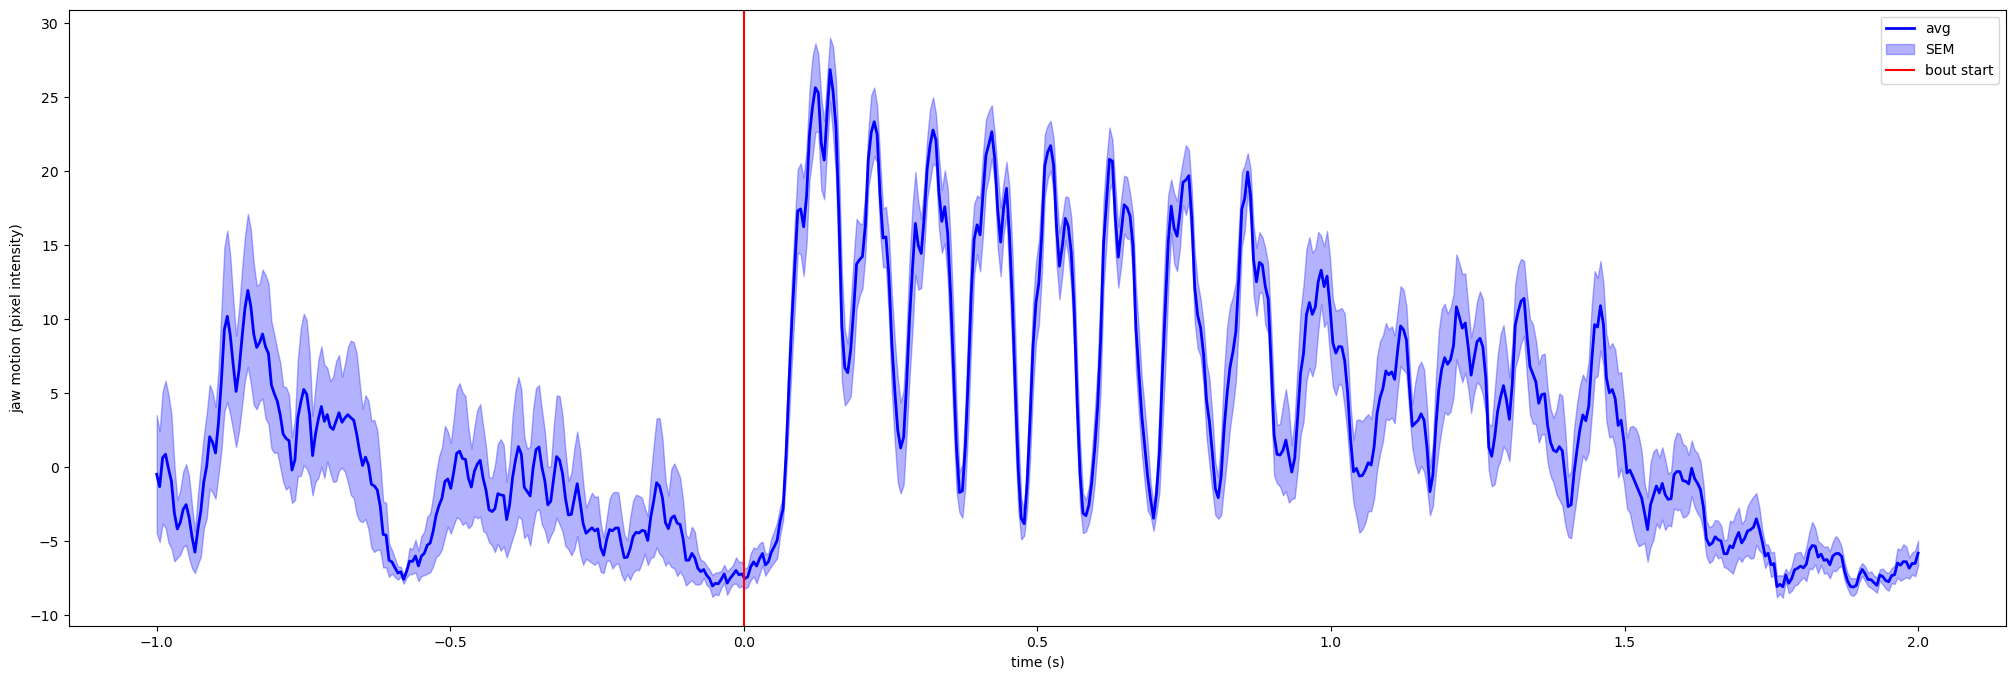

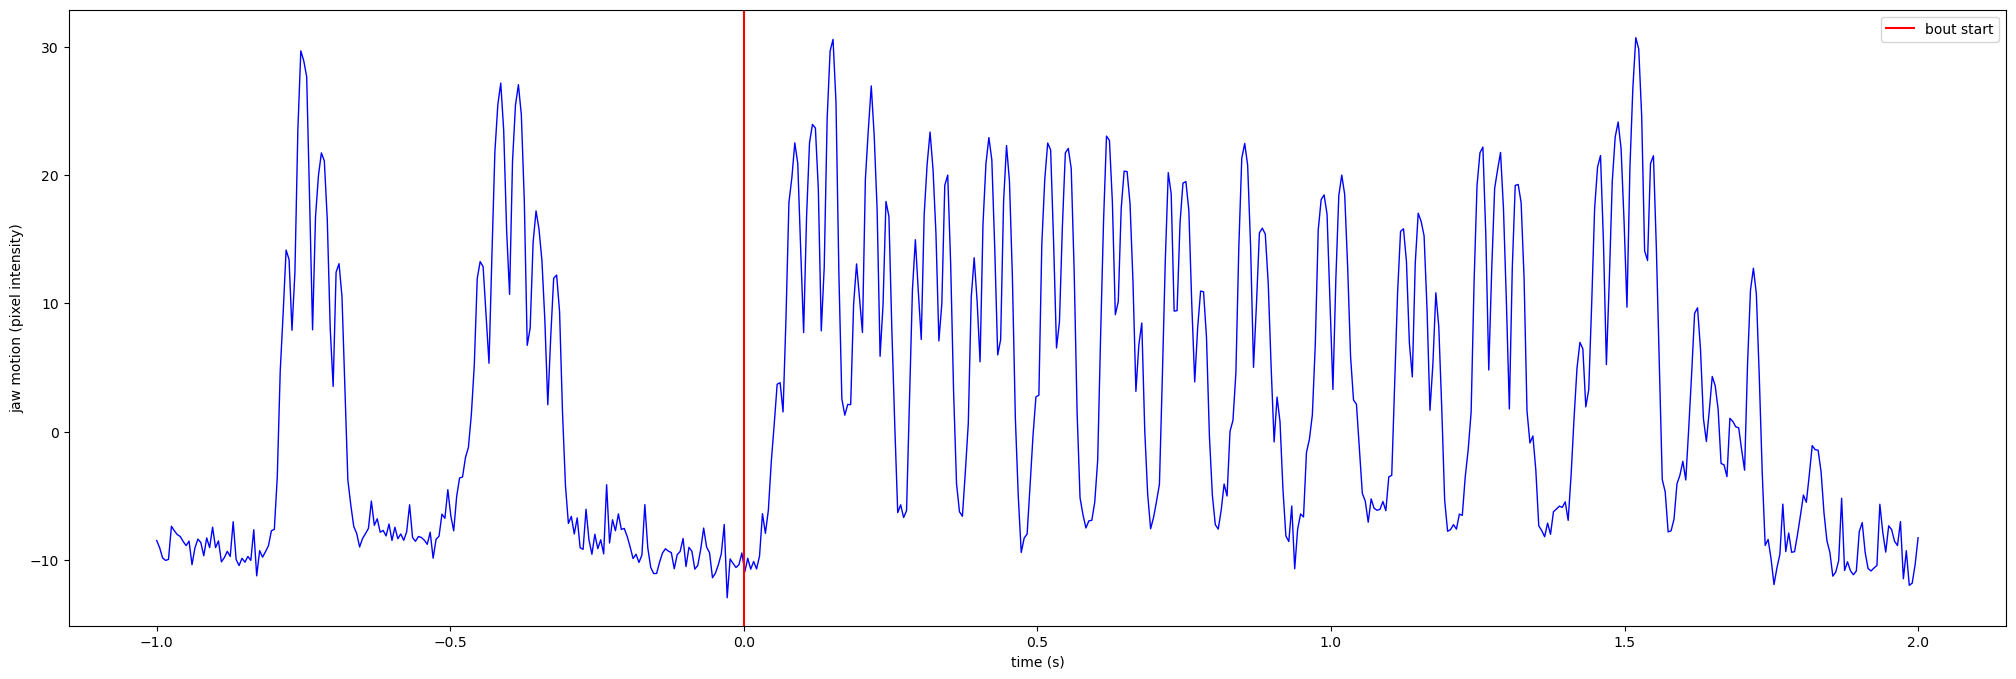

In [377]:
from scipy.stats import sem

list_bouts = np.array([
    jaw[3000:3600], 
    jaw[6895:7495], 
    jaw[11635:12235], 
    jaw[13530:14130], 
    jaw[15295:15895], 
    jaw[16465:17065], 
    jaw[19460:20060], 
    jaw[21905:22505], 
    jaw[24950:25550], 
    jaw[26525:27125]
])

avg_bouts = np.mean(list_bouts, axis=0)
sem_bouts = sem(list_bouts, axis=0)

x = np.linspace(-1, 2, len(avg_bouts))

plt.figure(figsize=(25, 8))
plt.plot(x, avg_bouts, color='blue', linewidth=2, label='avg')
plt.fill_between(x, avg_bouts - sem_bouts, avg_bouts + sem_bouts, color='blue', alpha=0.3, label='SEM')
plt.axvline(0, color = 'r', label='bout start')
plt.xlabel('time (s)')
plt.ylabel('jaw motion (pixel intensity)')
plt.legend()
plt.show()

plt.figure(figsize=(25, 8))
plt.plot(x, list_bouts[0], color='blue', linewidth=1)
#plt.fill_between(x, avg_bouts - sem_bouts, avg_bouts + sem_bouts, color='blue', alpha=0.3, label='SEM')
plt.axvline(0, color = 'r', label='bout start')
plt.xlabel('time (s)')
plt.ylabel('jaw motion (pixel intensity)')
plt.legend()
plt.show()

calculate z score for each cell, then find the calcium data for each cell that aligns with each lick bout

In [565]:
bouts = [[3000,3600], [6895,7495], [11635,12235], [13530,14130], [15295,15895], [16465,17065], [19460,20060], [21905,22505], [24950,25550], [26525,27125]]
allcells_bouts = []
x_bouts = []

for i, bout in enumerate(bouts):
    nidaq_bout_start = sidecam_frames[bout[0]]
    nidaq_bout_end = sidecam_frames[bout[1]-1]

    twop_indices_start = [np.where(twop_frames > nidaq_bout_start)[0][0]]
    twop_indices_start = twop_indices_start[0]
    bout_2p_indices = np.arange(twop_indices_start, twop_indices_start + 23)
    x_2p = np.linspace(-1, 2, len(bout_2p_indices))
    x_bouts.append(x_2p)

for i, cell in enumerate(C):
    zscore = (C[i] - np.mean(C[i])) / np.std(C[i])

    allbouts = [] 
    for i, bout in enumerate(bouts):
        nidaq_bout_start = sidecam_frames[bout[0]]
        nidaq_bout_end = sidecam_frames[bout[1]-1]

        twop_indices_start = [np.where(twop_frames > nidaq_bout_start)[0][0]]
        twop_indices_start = twop_indices_start[0]
        bout_2p_indices = np.arange(twop_indices_start, twop_indices_start + 23)
        x_2p = np.linspace(-1, 2, len(bout_2p_indices))

        bout_trace = zscore[bout_2p_indices]
        allbouts.append(bout_trace)

    allcells_bouts.append(allbouts)

plot example of z scored data over arbitrary time window

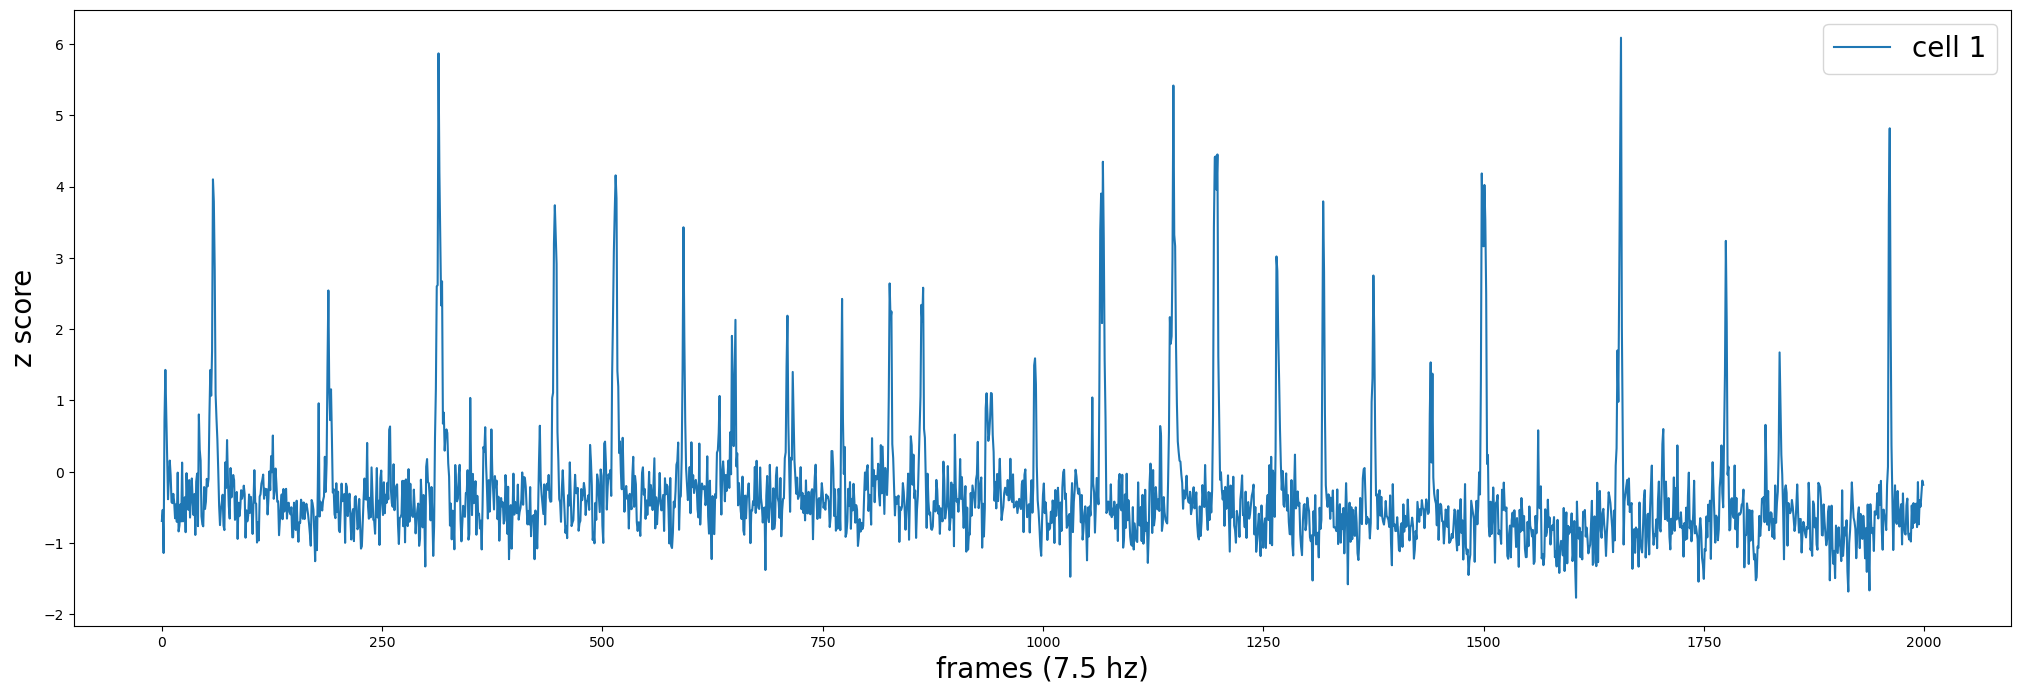

In [572]:
zscore_0 = (C[0] - np.mean(C[0])) / np.std(C[0])

plt.figure(figsize = (25, 8))
plt.plot(zscore_0[2000:4000], label='cell 1')
plt.xlabel('frames (7.5 hz)', fontsize=20)
plt.ylabel('z score', fontsize=20)
plt.legend(fontsize=20)
plt.show()

plot cell 0 calcium data aligned with first lick bout

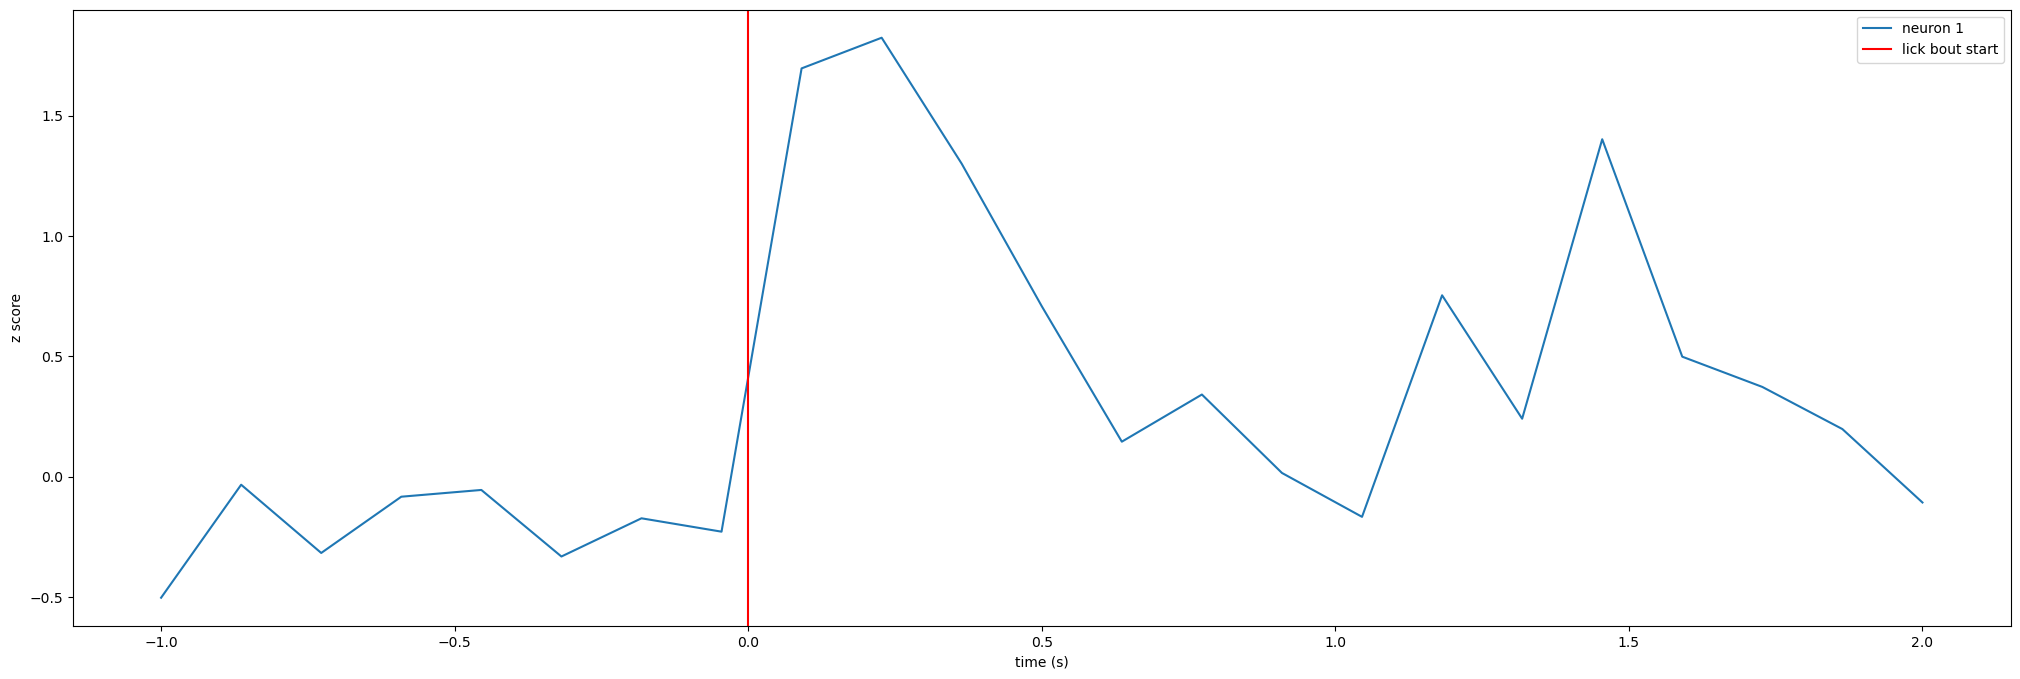

In [542]:
plt.figure(figsize = (25, 8))
plt.plot(x_2p, allcells_bouts[0][0], label='neuron 1')
plt.axvline(x=0, color='r', label='lick bout start')
plt.ylabel('z score')
plt.xlabel('time (s)')
plt.legend()
plt.show()

plot individual calcium data for all cells over first bout

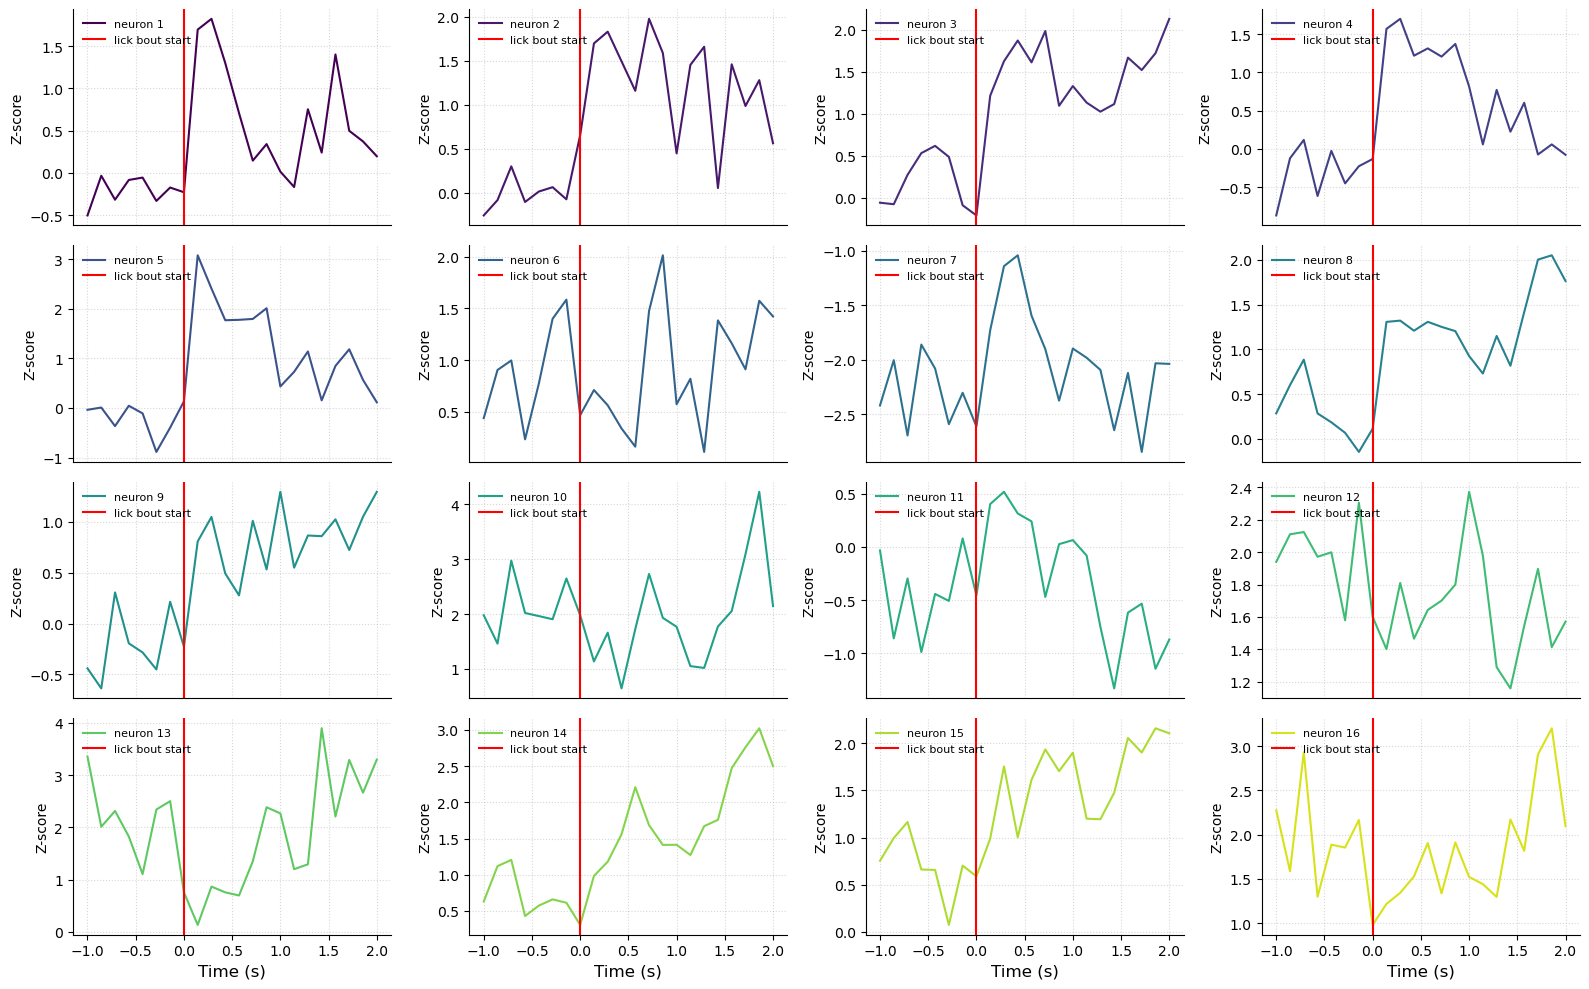

In [448]:
# bout 0 all cells
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 10), sharex=True)

# Plot each data series in its respective subplot
for i, ax in enumerate(axes.flat):
    ax.plot(x_2p, allcells_bouts[i][0], label=f'neuron {i+1}', color=plt.cm.viridis(i / 16))  # Color map for differentiation
    ax.axvline(x=0, color='r', label='lick bout start')  # Red dashed line for the event
    ax.set_ylabel('Z-score', fontsize=10)  # Unified y-axis label
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle=':', alpha=0.5)  # Add gridlines for better readability
    ax.legend(loc='upper left', fontsize=8, frameon=False)

    # Only show x-tick labels on the bottom row
    if i >= 12:  
        ax.set_xlabel('Time (s)', fontsize=12)
    else:
        ax.tick_params(axis='x', which='both', length=0)  # Hide x-tick marks

# Adjust spacing and layout for readability
plt.tight_layout()

# Show the plot
plt.show()

calculate and plot the average calcium data for each cell over all 10 lick bouts

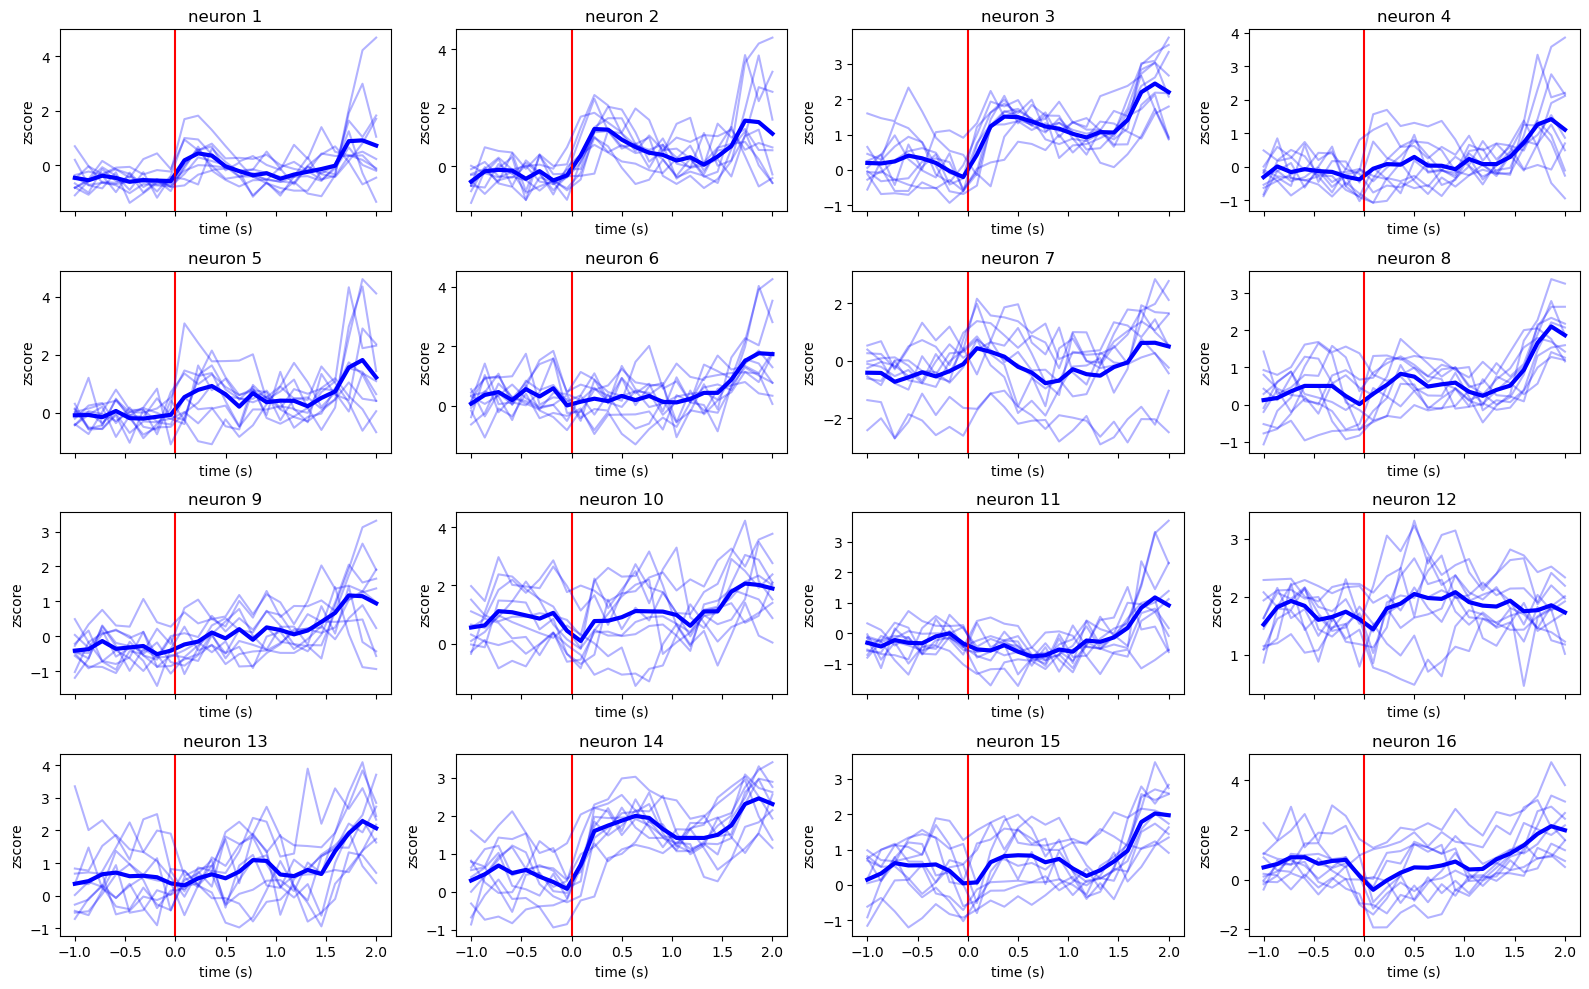

In [536]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 10), sharex=True)

axes = axes.flatten()

for j, (cell, ax) in enumerate(zip(C, axes)):
    cell_data = []
    
    for i, bout in enumerate(x_bouts):
        cell_data.append(allcells_bouts[j][i])
    
    cell_data = np.array(cell_data)
    cellavg = np.mean(cell_data, axis=0)

    ax.plot(x_bouts[0], cellavg, color='blue', linewidth=3, label='bout avg') 
    ax.axvline(0, color = 'r', label='bout start')
    
    for i, bout in enumerate(x_bouts):
        if i == 0:
            ax.plot(x_bouts[i], allcells_bouts[j][i], color='blue', alpha=0.3, label='indv bout')
        else:
            ax.plot(x_bouts[i], allcells_bouts[j][i], color='blue', alpha=0.3)
    
    ax.set_xlabel('time (s)')
    ax.set_ylabel('zscore')
    ax.set_title(f'neuron {j+1}')

plt.tight_layout()
plt.show()